In [1]:
from pathlib import Path

import torch
import torch.nn as nn
import yaml
from accelerate.utils import set_seed
from hydra.utils import instantiate
from loguru import logger
from torch.utils.data import DataLoader, Dataset
from transformers import AutoModel, AutoImageProcessor, get_scheduler
import torchvision.transforms.v2 as T
from torchmetrics.aggregation import MeanMetric
from grins.modeling.regress.loss.pairwise import TaskPairwiseCorrect
from safetensors.torch import load_file

from captum.attr import GuidedGradCam

import lovely_tensors as lt
lt.monkey_patch()

/home/pasquale/projects/GRINS/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-10-02 18:31:00.452 | INFO     | grins.config:<module>:11 - PROJ_ROOT path is: /home/pasquale/projects/GRINS


In [15]:
def min_max_norm(tensor):
    tensor = tensor.clone()
    tensor -= tensor.min()
    tensor /= tensor.max()
    return tensor

In [2]:
config_path = "configs/regress/resnet50_multilayer_head_unfrozen.yaml"

config_path = Path(config_path)
with config_path.open("r") as f:
    config_dict = yaml.safe_load(f)

config_dict["dataloaders"]["val_partial"]["batch_size"] = 1
config_dict["dataloaders"]["val_partial"]["num_workers"] = 0

config = instantiate(config_dict)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [3]:
device = "cpu"
path = "out/regress/resnet50/run_20250930_165519/checkpoints/checkpoint_2/model.safetensors"

In [4]:
# Set seed
set_seed(config.seed)

# Initialize model
tasks: list[str] = config.tasks
tasks_lookup = {task: i for i, task in enumerate(tasks)}
tasks_lookup_inv = {v: k for k, v in tasks_lookup.items()}
num_tasks = len(tasks)
processor: AutoImageProcessor = config.processor
backbone: AutoModel = config.backbone
model = config.model_partial(
    backbone=backbone,
    num_tasks=num_tasks,
)
logger.info("Model instantiated.")

model.load_state_dict(
    load_file(path, device=device)
)

2025-10-02 18:31:01.207 | INFO     | __main__:<module>:15 - Model instantiated.


<All keys matched successfully>

In [5]:
# Initialize datasets and dataloaders
transform: Dataset = config.datasets.transform
val_dss: list[Dataset] = [
    config.datasets.val_partial(question=task, transform=transform, processor=processor)
    for task in tasks
]
val_dls: list[DataLoader] = [
    config.dataloaders.val_partial(dataset=ds, collate_fn=ds.collate_fn) for ds in val_dss
]
logger.info("Datasets instantiated.")
for ds in val_dss:
    logger.info(f"Val dataset size for {ds.question}: {len(ds)}")


2025-10-02 18:31:27.982 | INFO     | __main__:<module>:10 - Datasets instantiated.
2025-10-02 18:31:27.983 | INFO     | __main__:<module>:12 - Val dataset size for livelier: 16145
2025-10-02 18:31:27.984 | INFO     | __main__:<module>:12 - Val dataset size for more beautiful: 9567
2025-10-02 18:31:27.984 | INFO     | __main__:<module>:12 - Val dataset size for more depressing: 6247
2025-10-02 18:31:27.985 | INFO     | __main__:<module>:12 - Val dataset size for more boring: 5923
2025-10-02 18:31:27.985 | INFO     | __main__:<module>:12 - Val dataset size for safer: 21893
2025-10-02 18:31:27.985 | INFO     | __main__:<module>:12 - Val dataset size for wealthier: 7424


In [6]:
# Loss and metrics
loss_function: nn.Module = config.loss_function_partial(num_tasks=num_tasks)
correct_function = TaskPairwiseCorrect()
accuracy_metric = MeanMetric()

# Optimizer and scheduler
params_to_optimize = list(model.parameters())
if loss_function.use_task_weighting:
    params_to_optimize += list(loss_function.parameters())


In [25]:
task_idx = 1
task = tasks[task_idx]
print(f"Evaluating task {task} ({task_idx})")

val_dl = val_dls[task_idx]
i, batch = next(enumerate(val_dl))

IndexError: list index out of range

In [8]:

model.eval()
loss_function.eval()
with torch.inference_mode():
    # Read batch
    images0, images1, labels, tasks = (
        batch["images0"],
        batch["images1"],
        batch["labels"],
        batch["questions"],
    )
    task_idxs = torch.tensor(
        [tasks_lookup[t] for t in tasks],
        dtype=torch.long,
        device=device,
    )

    # Forward pass
    scores0 = model(pixel_values=images0)  # [B, num_tasks]
    scores1 = model(pixel_values=images1)  # [B, num_tasks]
    
    if scores0.ndim == 1:
        scores0 = scores0.unsqueeze(1)
    if scores1.ndim == 1:
        scores1 = scores1.unsqueeze(1)

    # Compute loss
    loss, loss_per_task = loss_function(scores0, scores1, task_idxs, labels)

    # Compute accuracy
    correct = correct_function(scores0, scores1, task_idxs, labels)
    batch_accuracy = accuracy_metric(correct)

    # Log
    print(f"loss: {loss.item()}")
    print(f"accuracy: {batch_accuracy.item()}")
    print(f"Scores0: {scores0[:, task_idx]}")
    print(f"Scores1: {scores1[:, task_idx]}")
    print(f"Labels: {labels}")
    accuracy_metric.reset()



loss: 0.74790358543396
accuracy: 0.0
Scores0: tensor[1] [-0.295]
Scores1: tensor[1] [-0.188]
Labels: tensor[1] i64 [0]


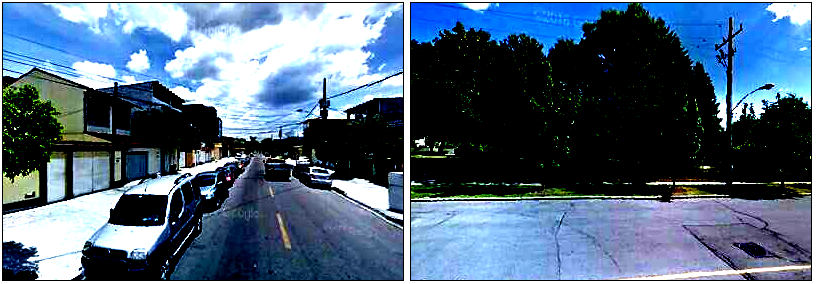

In [9]:
torch.cat([images0, images1], dim=0).rgb

In [10]:
layer = model.backbone.encoder.stages[-1].layers[-1].layer[-1].convolution
guided_gc = GuidedGradCam(model, layer)

In [23]:
images0.requires_grad = True
images1.requires_grad = True

attributions0 = guided_gc.attribute(images0, target=task_idx)
attributions1 = guided_gc.attribute(images1, target=task_idx)
attributions0 = min_max_norm(attributions0)
attributions1 = min_max_norm(attributions1)


/home/pasquale/projects/GRINS/.venv/lib/python3.12/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


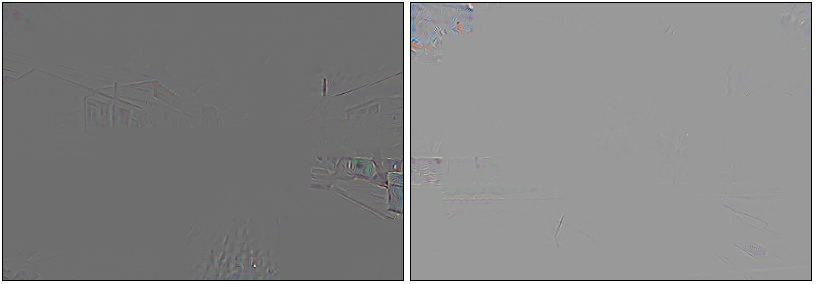

In [24]:
torch.cat([attributions0, attributions1], dim=0).rgb